# Cats vs Dogs Image Classifier using CNN

This project uses Convolutional Neural Networks (CNNs) with TensorFlow and Keras to classify images of cats and dogs. The model is trained on the Kaggle Dogs vs Cats dataset.

This notebook was developed as part of an internship project at IBM.


## 1. Install & Import Required Libraries

In [ ]:
# Install required packages (if not already installed)

!pip install -q kaggle opencv-python matplotlib numpy tensorflow

In [ ]:
# Import essential libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

## 2. Load Dataset from Kaggle

In this section, we upload our Kaggle API key, configure the environment, and download the "Dogs vs Cats" dataset from Kaggle using the Kaggle API. We then unzip the dataset to prepare it for processing.


In [ ]:
# Upload your kaggle.json file (Kaggle API credentials)
from google.colab import files
files.upload()  # Choose kaggle.json from your system

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vipul0503","key":"e7bbb93d795fe1d343b30e0bfeed59b6"}'}

In [ ]:
# Create a Kaggle directory and move kaggle.json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the key file

In [ ]:
# Download the Dogs vs Cats dataset from Kaggle
!kaggle datasets download -d biaiscience/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats
License(s): DbCL-1.0
 96% 783M/817M [00:05<00:00, 73.5MB/s]
100% 817M/817M [00:05<00:00, 148MB/s] 


In [ ]:
# Unzip the downloaded dataset into a new directory called 'data'
!unzip -q dogs-vs-cats.zip -d ./data

## 3. Explore the Dataset

Now that the dataset is downloaded and extracted, let's explore the image files. This includes checking the total number of images and previewing a few filenames to confirm successful extraction.


In [ ]:
# Define the path to the unzipped image directory
original_dir = './data/train'

# List the first 10 image filenames in the directory
print("Sample image filenames:", os.listdir(original_dir)[:10])

# Count and display the total number of image files
total_images = len(os.listdir(original_dir))
print("Total number of images in dataset:", total_images)

Sample image filenames: ['train']
Total number of images in dataset: 1


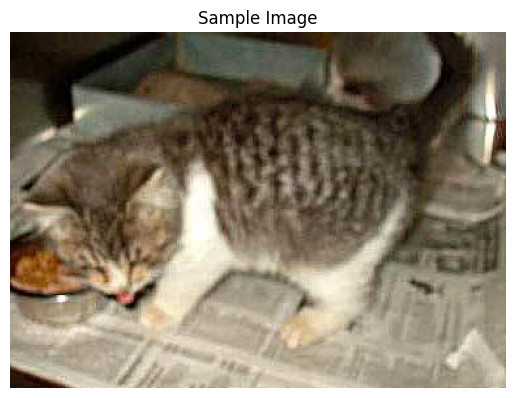

In [ ]:
# Updated original_dir path to point inside the nested 'train/train' folder
image_folder = './data/train/train'  # this contains all cat and dog images

# Get the list of image filenames
image_files = os.listdir(image_folder)

# Pick a sample image file (e.g., first one)
sample_image_path = os.path.join(image_folder, image_files[0])

# Read and display the image
import matplotlib.image as mpimg

img = mpimg.imread(sample_image_path)
plt.imshow(img)
plt.title("Sample Image")
plt.axis('off')
plt.show()

In [ ]:
# Verifying the dataset directory and listing sample files
original_dir = './data/train/train/'
all_files = os.listdir(original_dir)

# Print the total number of images and show the first 10 filenames
print(f"Total files found in original_dir: {len(all_files)}")
print(all_files[:10])

Total files found in original_dir: 25000
['cat.7107.jpg', 'cat.6263.jpg', 'dog.2175.jpg', 'dog.9552.jpg', 'dog.12445.jpg', 'dog.10021.jpg', 'dog.3548.jpg', 'dog.2319.jpg', 'cat.7594.jpg', 'dog.1485.jpg']


## 4. Preprocessing and Directory Setup

We will now prepare the dataset for model training by creating separate directories for training and validation sets. The original dataset contains 25,000 images of cats and dogs mixed in a single folder. We'll split 90% of the data into a training set and 10% into a validation set.


In [ ]:
import shutil
import random

# Path to the original dataset containing all 25,000 images
original_dir = './data/train/train'

# Paths for new directories
base_dir = './data_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Create class-specific folders
classes = ['cats', 'dogs']
for category in classes:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

# Shuffle and split data (90% train, 10% val)
filenames = os.listdir(original_dir)
random.shuffle(filenames)

for fname in filenames:
    if fname.startswith('cat') or fname.startswith('dog'):
        label = 'cats' if fname.startswith('cat') else 'dogs'
        src = os.path.join(original_dir, fname)

        if random.random() < 0.9:
            dst = os.path.join(train_dir, label, fname)
        else:
            dst = os.path.join(val_dir, label, fname)

        shutil.copyfile(src, dst)

In [ ]:
# Confirm number of images in each directory
print("Training cat images:", len(os.listdir(os.path.join(train_dir, 'cats'))))
print("Training dog images:", len(os.listdir(os.path.join(train_dir, 'dogs'))))
print("Validation cat images:", len(os.listdir(os.path.join(val_dir, 'cats'))))
print("Validation dog images:", len(os.listdir(os.path.join(val_dir, 'dogs'))))

Training cat images: 11261
Training dog images: 11297
Validation cat images: 1239
Validation dog images: 1203


## 5. Data Augmentation & Generators

To improve model generalization and prevent overfitting, we apply data augmentation to the training images. This includes operations like rotation, zooming, shifting, and flipping. We use `ImageDataGenerator` to perform real-time image augmentation and to load batches of images efficiently.


In [ ]:
# Create data generators for training and validation sets
# Applies real-time data augmentation to training images and rescales all images

train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values
    rotation_range=40,           # Random rotation
    width_shift_range=0.2,       # Horizontal shift
    height_shift_range=0.2,      # Vertical shift
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'          # Fill in missing pixels
)

# Validation data should not be augmented — only rescaled
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load images from the train and validation directories using the generators

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),      # Resize all images to 150x150
    batch_size=32,               # Number of images per batch
    class_mode='binary'          # Binary labels: cat or dog
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 22558 images belonging to 2 classes.
Found 2442 images belonging to 2 classes.


## 6. Build the CNN Model

Now we define the architecture of our Convolutional Neural Network (CNN). This model consists of multiple convolutional layers with ReLU activations, followed by max pooling, dropout for regularization, and dense layers. The final layer uses a sigmoid activation for binary classification (cat or dog).


In [ ]:
# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# View Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,873 (1.62 MB)

 Trainable params: 422,657 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## 7. Train the Model

With the CNN model defined and compiled, we now train it using the `fit()` method. We pass in the training and validation generators, specify the number of epochs, and define how many batches to run per epoch.


In [ ]:
# Train the model on the training set and validate on the validation set

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),   # Number of batches per epoch
    epochs=10,                              # You can increase for better performance
    validation_data=val_generator,
    validation_steps=len(val_generator)     # Number of validation batches per epoch
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 1737s 2s/step - accuracy: 0.5971 - loss: 0.7438 - val_accuracy: 0.6806 - val_loss: 0.5967
Epoch 2/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 1725s 2s/step - accuracy: 0.6831 - loss: 0.6036 - val_accuracy: 0.5045 - val_loss: 1.2355
Epoch 3/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 1751s 2s/step - accuracy: 0.7353 - loss: 0.5428 - val_accuracy: 0.7039 - val_loss: 0.5767
Epoch 4/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 1732s 2s/step - accuracy: 0.7696 - loss: 0.4840 - val_accuracy: 0.7637 - val_loss: 0.4999
Epoch 5/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 1727s 2s/step - accuracy: 0.8055 - loss: 0.4223 - val_accuracy: 0.7310 - val_loss: 0.5804
Epoch 6/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 1719s 2s/step - accuracy: 0.8308 - loss: 0.3784 - val_accuracy: 0.8198 - val_loss: 0.4006
Epoch 7/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 1710s 2s/step - accuracy: 0.8500 - loss: 0.3372 - val_accuracy: 0.8526 - val_loss: 0.3462
Epoch 8/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 1763s 2s/step - accuracy: 0.8610 - loss: 0.3110 - 

In [ ]:
# Save the trained model in keras format
model.save('cats_vs_dogs_cnn.keras')

In [ ]:
# Create 'images' directory if it doesn't already exist
if not os.path.exists('images'):
    os.makedirs('images')

## 8. Evaluate the Model & Plot Accuracy/Loss

Now that the model is trained, we evaluate its performance using training and validation accuracy and loss. We also visualize these metrics to observe learning behavior over epochs.


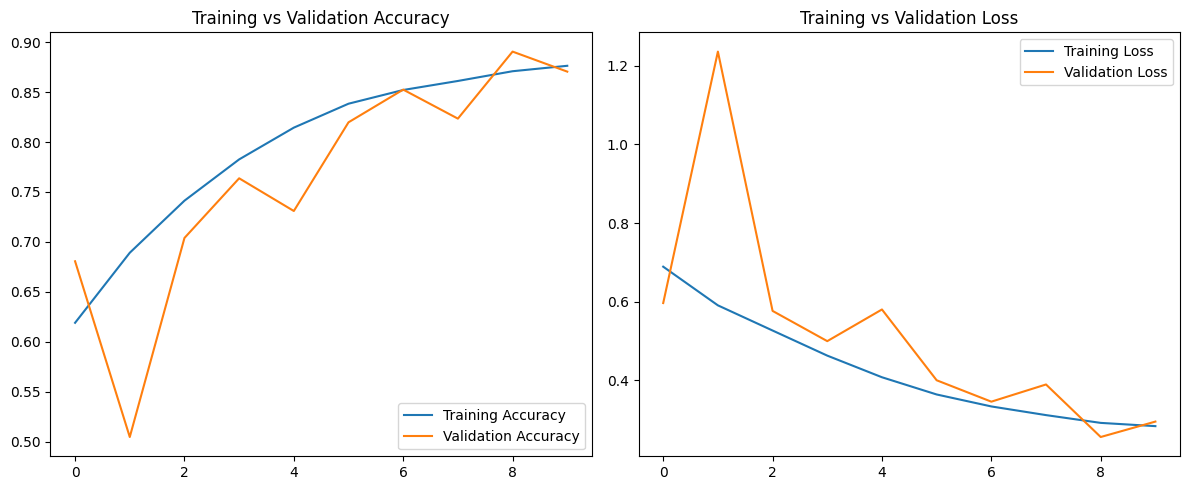

In [ ]:
# Plot training and validation accuracy and loss over epochs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.show()

## 9. Make Predictions on New Images

Now that the model is trained and saved, let's load a sample image and make predictions using the CNN. We'll display the image along with its predicted class (Cat or Dog).


In [ ]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('cats_vs_dogs_cnn.keras')

In [ ]:
import os

# See first 5 images from the 'cats' validation folder
print(os.listdir(val_dir + '/cats')[:5])

# Or see a few dog images
print(os.listdir(val_dir + '/dogs')[:5])

['cat.7107.jpg', 'cat.6263.jpg', 'cat.8864.jpg', 'cat.1654.jpg', 'cat.7520.jpg']
['dog.10342.jpg', 'dog.7594.jpg', 'dog.2468.jpg', 'dog.7464.jpg', 'dog.5536.jpg']


In [ ]:
# Load and preprocess a sample image
from tensorflow.keras.preprocessing import image

img_path = os.path.join(val_dir, 'cats/cat.8864.jpg')  # Update with any valid image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

In [ ]:
# Make prediction
prediction = model.predict(img_array)
print("Predicted:", "Dog" if prediction[0] > 0.5 else "Cat")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Predicted: Cat


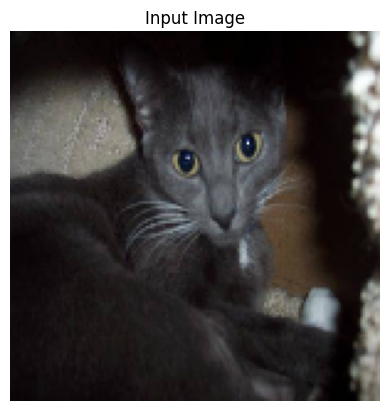

In [ ]:
# Display the image
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title("Input Image")
plt.axis('off')
plt.show()

## 10. Conclusion

In this project, we successfully developed a deep learning-based image classifier using Convolutional Neural Networks (CNNs) to distinguish between cats and dogs. The model was trained on the Kaggle Dogs vs Cats dataset consisting of 25,000 labeled images.

### Key Achievements:
- Implemented data preprocessing and real-time data augmentation.
- Built a custom CNN architecture using TensorFlow and Keras.
- Achieved a training accuracy of approximately **87.79%** and validation accuracy of **87.06%**.
- Visualized training progress using accuracy and loss curves.
- Demonstrated prediction capability on new images.

This project was developed as part of my internship at **IBM**, showcasing an end-to-end machine learning workflow. It strengthened my practical understanding of image classification, CNN design, and project structuring on platforms like Google Colab and GitHub.

The entire pipeline—from data acquisition and model training to evaluation and prediction—provides a solid foundation for future computer vision projects and real-world deployment.


In [ ]:
!pip freeze > requirements.txt
